In [104]:
import numpy as npa

import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10000)

import altair as alt
alt.data_transformers.disable_max_rows()

import glob
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import act
import pyart
import xarray as xr
import os


import sys
sys.path.append('../')
import soslib

In [105]:
sail_dl = [-106.987900, 38.956160]

In [106]:
output_dir = 'doppler_lidar_daily'

In [107]:
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

# Identify datastreams

In [108]:
ds_dl_rhi = 'gucdlrhiM1.b1'

startdate = (datetime.date.today() - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
enddate = datetime.date.today().strftime("%Y-%m-%d")

# Download datasets

In [7]:
act.discovery.download_data(username, token, ds_dl_rhi, startdate, enddate, output=output_dir)

No files returned or url status error.
Check datastream name, start, and end date.


[]

In [109]:
dl_rhi_files = glob.glob(''.join(['./',output_dir, '/', ds_dl_rhi,'*cdf']))

In [117]:
dl_rhi = act.io.armfiles.read_netcdf(dl_rhi_files)

In [118]:
dl_rhi

<xarray.Dataset>
Dimensions:                 (time: 8494, range: 400)
Coordinates:
  * time                    (time) datetime64[ns] 2023-01-12T00:01:18.210000 ...
  * range                   (range) float32 15.0 45.0 ... 1.196e+04 1.198e+04
Data variables:
    base_time               (time) datetime64[ns] 2023-01-12 ... 2023-01-12
    time_offset             (time) datetime64[ns] 2023-01-12T00:01:18.210000 ...
    qc_time                 (time) int32 dask.array<chunksize=(181,), meta=np.ndarray>
    azimuth                 (time) float32 dask.array<chunksize=(181,), meta=np.ndarray>
    elevation               (time) float32 dask.array<chunksize=(181,), meta=np.ndarray>
    radial_velocity         (time, range) float32 dask.array<chunksize=(181, 400), meta=np.ndarray>
    qc_radial_velocity      (time, range) int32 dask.array<chunksize=(181, 400), meta=np.ndarray>
    intensity               (time, range) float32 dask.array<chunksize=(181, 400), meta=np.ndarray>
    attenuated_backscatter  (time, range) float32 dask.array<chunksize=(181, 400), meta=np.ndarray>
    lat                     (time) float32 38.96 38.96 38.96 ... 38.96 38.96
    lon                     (time) float32 -107.0 -107.0 ... -107.0 -107.0
    alt                     (time) float32 2.886e+03 2.886e+03 ... 2.886e+03
Attributes: (12/37)
    command_line:                dl_ingest --max-runtime 0 -s guc -f M1
    process_version:             ingest-dl-2.24-0.el7
    dod_version:                 dlrhi-b1-1.1
    site_id:                     guc
    facility_id:                 M1: Mt Crested Butte, Colorado
    input_source:                /data/collection/guc/gucdlM1.00/User5_193_20...
    ...                          ...
    target_altitude:             2881.000000
    history:                     created by user dsmgr on machine prod-proc2....
    _file_dates:                 ['20230112', '20230112', '20230112', '202301...
    _file_times:                 ['000118', '000433', '010118', '010433', '02...
    _datastream:                 gucdlrhiM1.b1
    _arm_standards_flag:         1

# Examine RHI data

In [119]:
src_rhi = dl_rhi.to_dataframe().reset_index()

# Convert time zone

In [120]:
src_rhi['time'] = src_rhi['time'] - datetime.timedelta(hours = 6)
src_rhi['date'] = src_rhi['time'].dt.date

# Filter with SNR

In [122]:
src_rhi['SNR'] = src_rhi['intensity'] - 1
src_rhi.loc[src_rhi.eval('SNR < 0.008'), 'radial_velocity'] = np.nan

## RHI: convert polar coordinates to rectangular coords with the radar at (0,0)

In [123]:
src_rhi['x'] = src_rhi['range']*np.cos(np.deg2rad(src_rhi['elevation']))
src_rhi['z'] = src_rhi['range']*np.sin(np.deg2rad(src_rhi['elevation']))

In [124]:
src_rhi

,time,range,base_time,time_offset,qc_time,azimuth,elevation,radial_velocity,qc_radial_velocity,intensity,attenuated_backscatter,lat,lon,alt,date,SNR,x,z
0,2023-01-11 18:01:18.210,15.0,2023-01-12,2023-01-12 00:01:18.210,4,0.0,-0.0,NaN,0,0.727996,-0.000015,38.956158,-106.987854,2886.0,2023-01-11,-0.272004,15.0,-0.000000
1,2023-01-11 18:01:18.210,45.0,2023-01-12,2023-01-12 00:01:18.210,4,0.0,-0.0,-1.2613,0,3.214628,0.000125,38.956158,-106.987854,2886.0,2023-01-11,2.214628,45.0,-0.000000
2,2023-01-11 18:01:18.210,75.0,2023-01-12,2023-01-12 00:01:18.210,4,0.0,-0.0,-1.4906,0,5.071815,0.000230,38.956158,-106.987854,2886.0,2023-01-11,4.071815,75.0,-0.000000
3,2023-01-11 18:01:18.210,105.0,2023-01-12,2023-01-12 00:01:18.210,4,0.0,-0.0,-0.0382,0,8.290289,0.000413,38.956158,-106.987854,2886.0,2023-01-11,7.290289,105.0,-0.000000
4,2023-01-11 18:01:18.210,135.0,2023-01-12,2023-01-12 00:01:18.210,4,0.0,-0.0,-0.2675,0,7.876724,0.000391,38.956158,-106.987854,2886.0,2023-01-11,6.876724,135.0,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397595,2023-01-12 17:04:23.740,11865.0,2023-01-12,2023-01-12 23:04:23.740,0,0.0,180.0,NaN,0,0.997244,-0.000012,38.956158,-106.987854,2886.0,2023-01-12,-0.002756,-11865.0,-0.001037
3397596,2023-01-12 17:04:23.740,11895.0,2023-01-12,2023-01-12 23:04:23.740,0,0.0,180.0,NaN,0,1.002898,0.000012,38.956158,-106.987854,2886.0,2023-01-12,0.002898,-11895.0,-0.001040
3397597,2023-01-12 17:04:23.740,11925.0,2023-01-12,2023-01-12 23:04:23.740,0,0.0,180.0,NaN,0,0.992672,-0.000031,38.956158,-106.987854,2886.0,2023-01-12,-0.007328,-11925.0,-0.001043
3397598,2023-01-12 17:04:23.740,11955.0,2023-01-12,2023-01-12 23:04:23.740,0,0.0,180.0,NaN,0,0.993423,-0.000028,38.956158,-106.987854,2886.0,2023-01-12,-0.006577,-11955.0,-0.001045


In [125]:
src_rhi['time_beginning_of_hour'] = src_rhi['time'].apply(lambda dt: dt.replace(minute=0, second=0, microsecond=0))

# Get ground profile

In [126]:
lon =     dl_rhi['lon'].values[0]
lat =     dl_rhi['lat'].values[0] 
bearing =     270
radius =     3000
spacing = 10

In [127]:
import geopy
import geopy.distance
import shapely.geometry
import py3dep

In [128]:
radar_location = geopy.Point(lat, lon)
radar_elevation = py3dep.elevation_bycoords(
    [(radar_location.longitude, radar_location.latitude)]
)[0]

In [129]:
positive_distance = geopy.distance.distance(
    kilometers=radius
).destination(
    point=radar_location, 
    bearing=bearing
)
negitive_distance = geopy.distance.distance(
    kilometers=radius
).destination(
    point=radar_location, 
    bearing=bearing-180
)
line = shapely.geometry.LineString([
    shapely.geometry.Point(positive_distance.longitude, positive_distance.latitude),
    shapely.geometry.Point(radar_location.longitude, radar_location.latitude),
    shapely.geometry.Point(negitive_distance.longitude, negitive_distance.latitude)
])

In [130]:
elevation_profile = py3dep.elevation_profile(line, spacing=spacing, crs='EPSG:4326')
elevation_profile.values = elevation_profile.values - radar_elevation
elevation_profile_df = elevation_profile.to_dataframe().reset_index()
elevation_profile_df['distance'] = elevation_profile_df['distance'] - radius
elevation_profile_df['zero'] = 0

ClientPayloadError: Response payload is not completed

In [ ]:
west_east_elev_profile_df = soslib.get_radar_scan_ground_profile(
    dl_rhi['lon'].values[0], 
    dl_rhi['lat'].values[0], 
    270,
    3000
)

KeyboardInterrupt: 

In [ ]:
alt.Chart(west_east_elev_profile_df).mark_area().encode(
    alt.X('distance:Q', scale=alt.Scale(nice=False), title = 'Distance (m)'),
    alt.Y(
        'elevation', 
        title='Elevation/Altitude (m)', 
        # scale=alt.Scale(zero=False, domain = [2750, 3200])
    )
).properties(width=500)

(-106.987854, 38.956158)

In [ ]:
alt.Chart(east_west_elevation_profile_df).mark_area().encode(
    alt.X('distance:Q', scale=alt.Scale(nice=False), title = 'Distance (m)'),
    alt.Y(
        'elevation', 
        title='Elevation/Altitude (m)', 
        # scale=alt.Scale(zero=False, domain = [2750, 3200])
    )
).properties(width=500)

/Users/elischwat/mambaforge/envs/arm/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

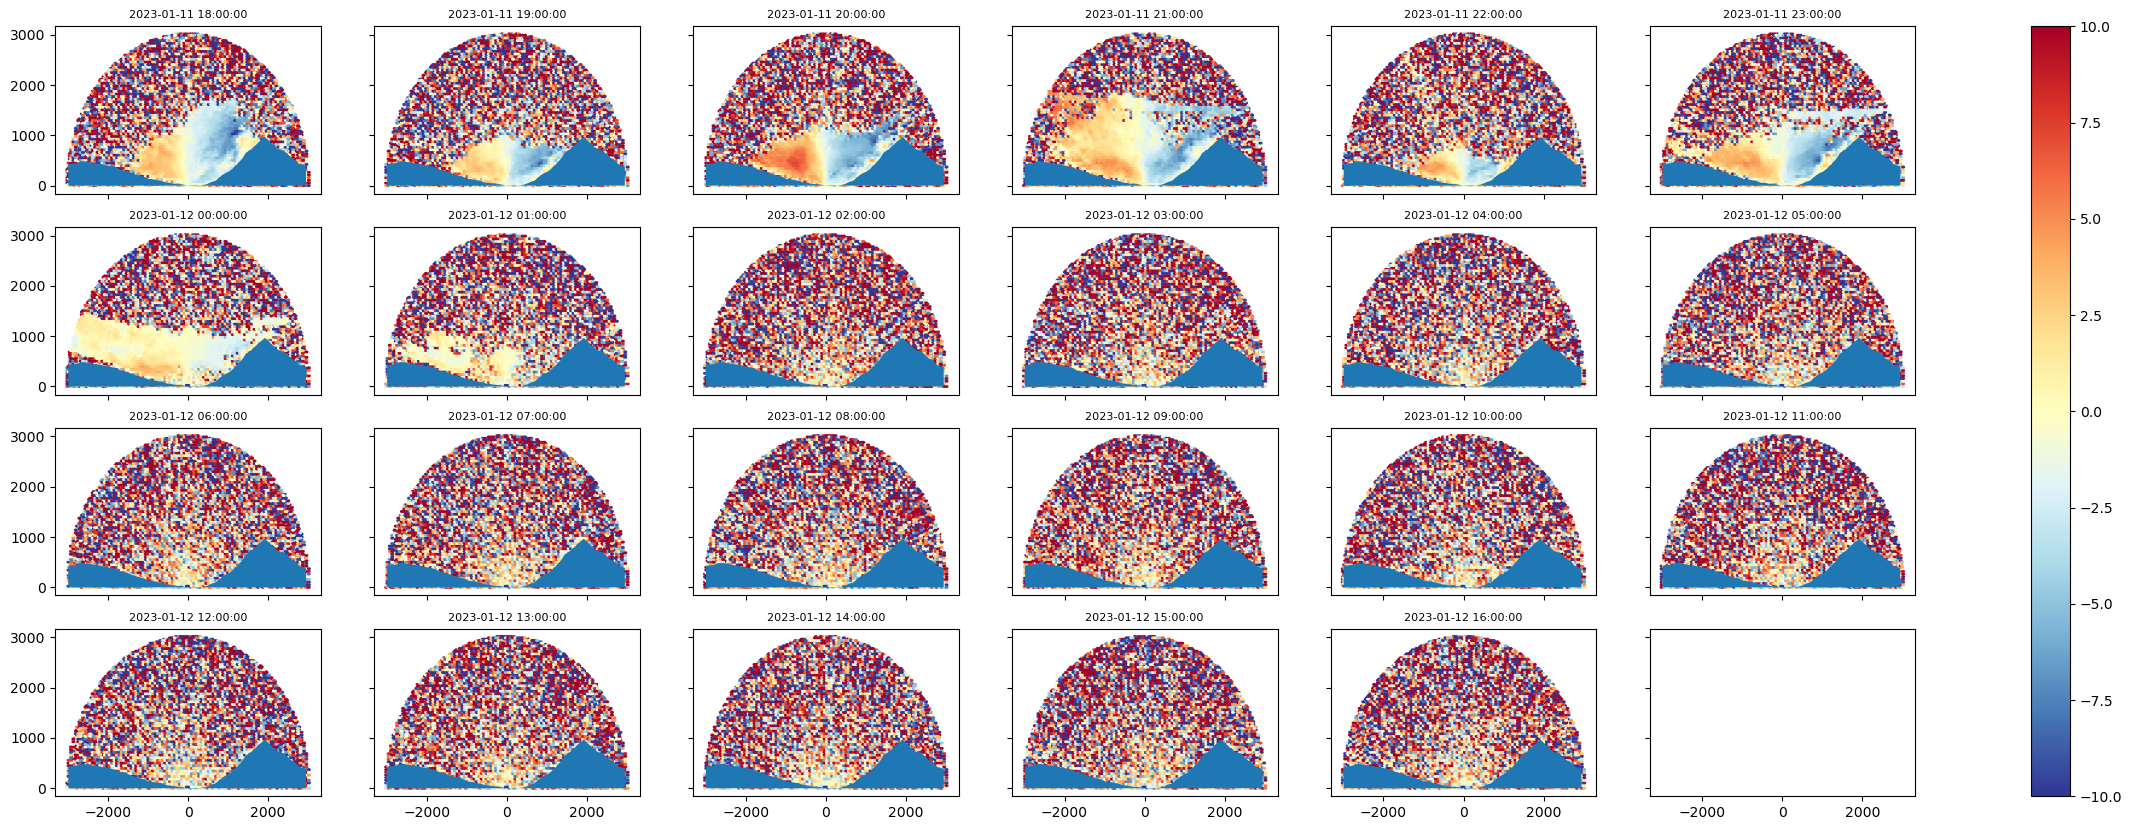

In [ ]:
src = src_rhi[src_rhi['azimuth'] == 270].query('range <= 3035')
plot_hours = np.arange(0,24)

fig, axes = plt.subplots(
    4, 
    6, 
    figsize=(30,10), 
    sharex=True, sharey=True
)


for i_day, day_and_hour in enumerate(src['time_beginning_of_hour'].unique()):
    local_src = src[src['time_beginning_of_hour'] == day_and_hour]
    ax = axes.flatten()[i_day]
    hexplot = ax.hexbin(local_src['x'], local_src['z'], C=local_src['radial_velocity'], cmap='RdYlBu_r', clim=(-10, 10))
    # ax.annotate(f"{day}:00", xy=(-900, 900))
    # ax.title.set_text(datetime.datetime(day_and_hour).strftime("%Y-%m-%d %h"))
    ax.title.set_text(pd.to_datetime(day_and_hour))
    ax.title.set_fontsize(8)
    # ax.set_xlim(-1000, 1000)
    # ax.set_ylim(0, 1000)
    ax.fill_between(
        east_west_elevation_profile_df['distance'],
        0,
        east_west_elevation_profile_df['elevation']
    )
fig.colorbar(hexplot, ax=axes.ravel().tolist())